# CSM148 Project 3 - Khanh Nguyen

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn import decomposition
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import statsmodels.api as sm
random.seed(42) 

id: unique identifier  

gender: "Male", "Female" or "Other"  

age: age of the patient  

hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension  

heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart  
disease

ever_married: "No" or "Yes"  

work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"  

Residence_type: "Rural" or "Urban"  

avg_glucose_level: average glucose level in blood  

bmi: body mass index  

smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*  

stroke: 1 if the patient had a stroke or 0 if not  

In [2]:
import warnings
warnings.filterwarnings('ignore') 

## Getting and exploring the data

In [3]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [4]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Dropping unnecessary data

In [5]:
df.drop(['id'], axis = 1, inplace=True)

In [6]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [8]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


With only 4 non-binary numerical features, it's hard to determine any meaning relations between the features and stroke risk. More work needs to be done with the categorical data before buildinga model.

In [9]:
df.shape

(5110, 11)

In [10]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

It appears that the bmi column has 95 missing values.

In [11]:
df[df['stroke'] == 1].shape

(249, 11)

In [12]:
df[pd.isnull(df['bmi']) & df['stroke'] == 1].shape

(40, 11)

It would be unwise to drop the rows with missing `bmi` values since 40/249 patients positive for stroke have missing `bmi` values. For a dataset with little positive stroke risk observations, it is best to keep the data as is for now until the imputation phase. Also, only 249/5110 observations are positive for stroke risk. There is clearly an imbalanced dataset. We will choose a method to deal with this later.

In [13]:
df.select_dtypes(include=['object']).apply(lambda col: len(col.unique()))

gender            3
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
dtype: int64

Since each categorical feature has a low amount of distinct values, it is fine to one-hot encode without running into dimensionality problems later. If needed, PCA is also an option for dimensionality reduction and reducing overfitting later on.

Overall, the best indicator for stroke risk is age, and while it is has weak correlation, doctors should still be aware of that.

## Visualizing the data 

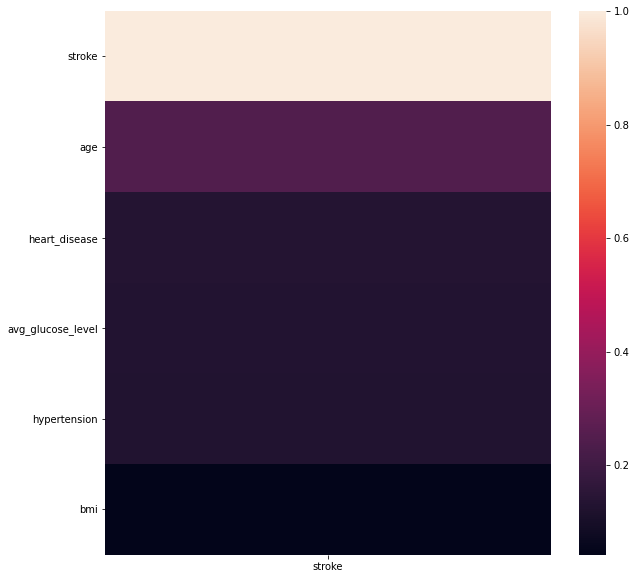

age                  0.245257
hypertension         0.127904
heart_disease        0.134914
avg_glucose_level    0.131945
bmi                  0.042374
stroke               1.000000
Name: stroke, dtype: float64

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr()[['stroke']].sort_values(by=['stroke'], ascending=False))
plt.show()
df.corr()['stroke']

As the graph shows, `age` is the feature with the highest correlation to stroke. This is reasonable as older people are more prone to health problems. However, there correlation is still very small with only a correlation coefficient of .25 .

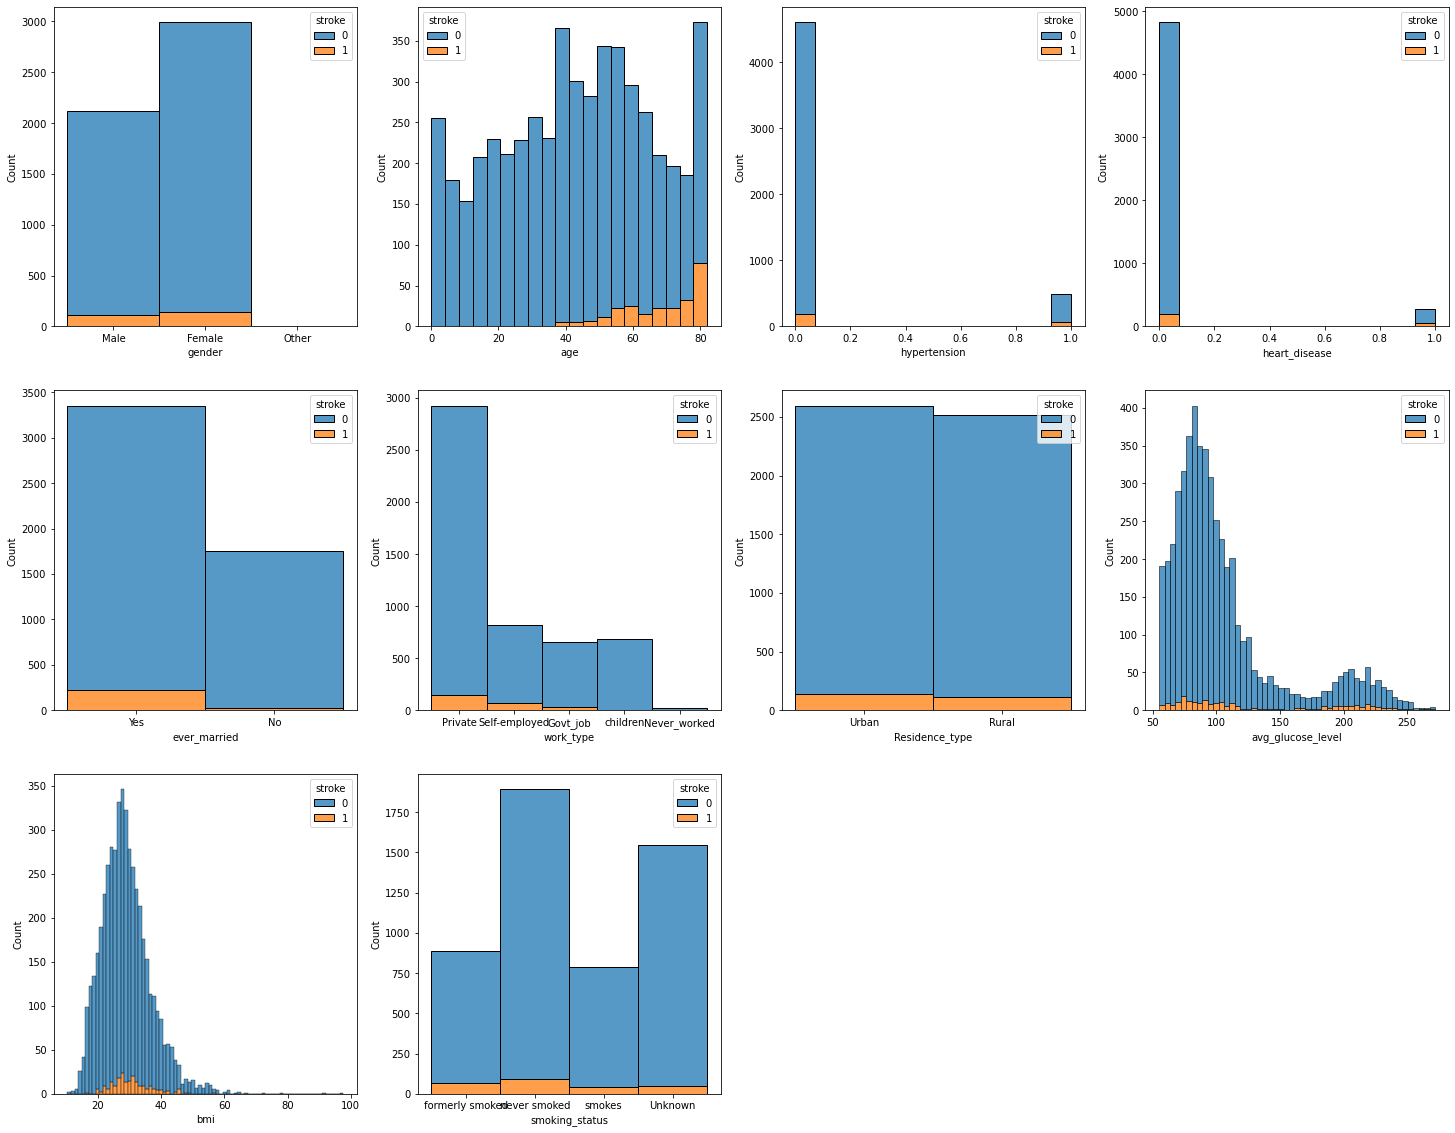

In [15]:
fig, ax = plt.subplots(3,4,figsize=(25,20))
ax = ax.flatten()
for i in range(10):
    sns.histplot(x=df.iloc[:,i], hue = df['stroke'], ax=ax[i], multiple="stack")
fig.delaxes(ax[10])
fig.delaxes(ax[11])
plt.show()

The age histogram shows that most strokes happen within older age groups. The bmi histogram shows that an increase in bmi does not mean an increase in stroke risk. Most people with stroke risks had bmi between 25-35. This observation can be a little flawed as less data was collected for people with higher bmi. Looking at the various plots, it looks like the data won't be linearly separable.

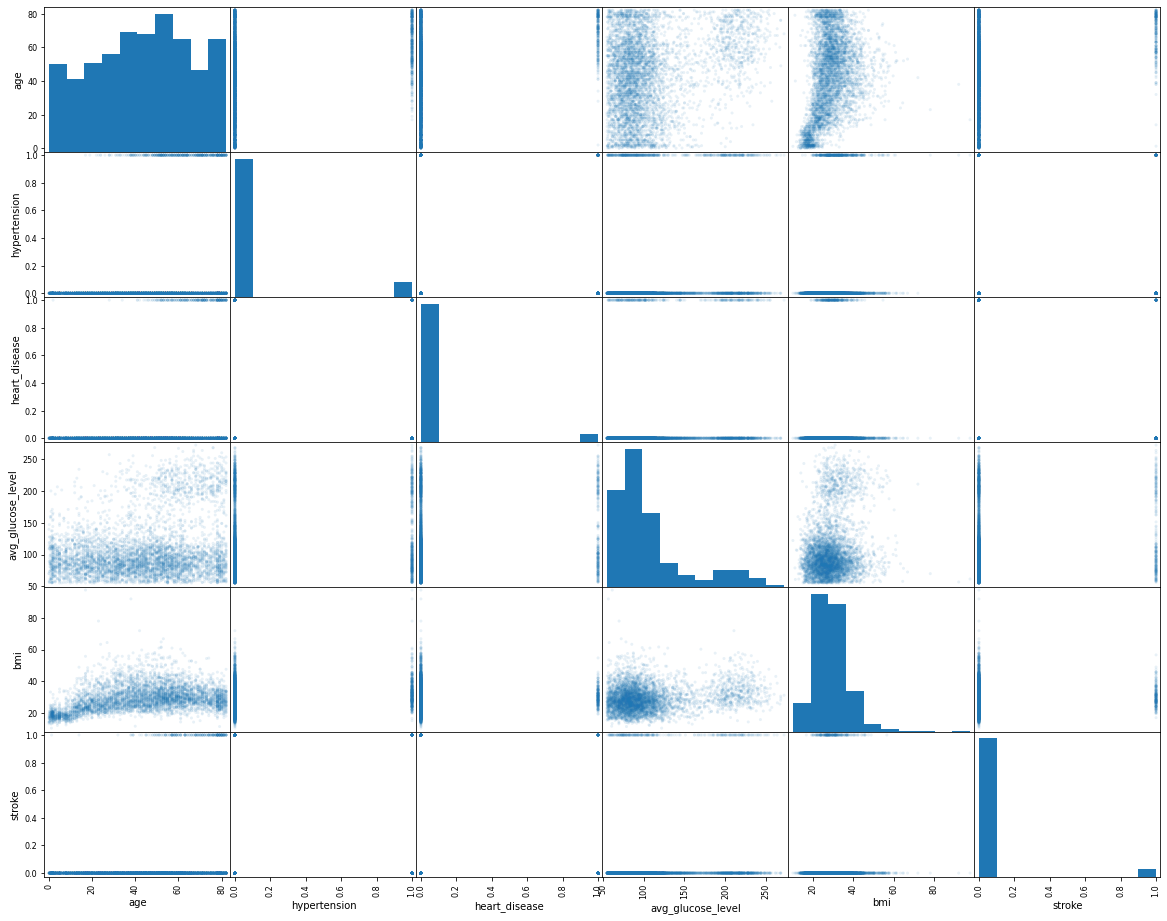

In [16]:
attributes = df.columns
scatter_matrix(df[attributes], figsize=(20, 16), alpha=0.1)
plt.show()

For now, it's difficult to draw any meaningful correlation from the scatter matrix yet as many features are still categorical. 

## Imputation, Augmentation, and Pipelining

Before moving on, as seen earlier, `ever_married` is a categorical feature that only has 2 unique values that represent yes or no. It is better to label encode them into binary instead of hot encoded them to slightly reduce dimensionality issues.

In [17]:
converter = {'ever_married': {'No': 0, 'Yes': 1}}
df.replace(converter, inplace=True)

Save the label column as a separate array and then drop it from the dataframe. 

In [18]:
stroke = df['stroke']
df.drop(['stroke'], axis=1, inplace=True)

In [19]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,1,Private,Urban,228.69,36.6,formerly smoked
1,Female,61.0,0,0,1,Self-employed,Rural,202.21,NaN,never smoked
2,Male,80.0,0,1,1,Private,Rural,105.92,32.5,never smoked
3,Female,49.0,0,0,1,Private,Urban,171.23,34.4,smokes
4,Female,79.0,1,0,1,Self-employed,Rural,174.12,24.0,never smoked


Imputing the missing bmi data is a priority. While using the median to impute is a simple choice, it simply isn't accurate enough. I am opting for a more learning based approach. Regression imputation is can be a good choice, but as seen above, the dataset isn't quite linear enough to warrant using linear regression. I am opting for KNN imputation since its nearest neighbor approach can work well with nonlinear data. I chose 200 nearest neighbors since it is approximately 5 percent for a dataset of 5000. Since KNN is sensitive to the relative magnitude of the data, I will scale the data first using Min-Max Scaler.

In [20]:
knnimputer = KNNImputer(n_neighbors=200)

num_pipeline = Pipeline([
        ('std_scaler', MinMaxScaler()),
        ('imputer', knnimputer), 
    ])

categorical_features = list(df.select_dtypes(include=['object']).columns)
numerical_features = list(df.select_dtypes(include=['float64', 'int64']).columns)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(), categorical_features),
    ])

df_prepared = full_pipeline.fit_transform(df)

In [21]:
df_prepared

array([[0.81689453, 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.74365234, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.97558594, 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.42626953, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.62158203, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.53613281, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# Correlations and values

In [22]:
stats_OLS = sm.OLS(stroke, df_prepared)
results_stats = stats_OLS.fit()

In [23]:
print(results_stats.summary())

                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     29.35
Date:                Sun, 30 May 2021   Prob (F-statistic):           1.24e-85
Time:                        15:54:05   Log-Likelihood:                 822.16
No. Observations:                5110   AIC:                            -1610.
Df Residuals:                    5093   BIC:                            -1499.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2535      0.018     14.311      0.0

After running a basic OLS regression, we can see that the R-squared value is very low, meaning there is very little correlation between the features and classes. We can see that for variables x1,x2,x3,x4, the P value is 0, meaning we can reject the null hypothesis that the correlation is due by chance. Looking at the t-values for each of the predictors, x1 seems to be considerably more significant than the others.

# Logistic Regression

Before I test the many diffrent machine learning models, I will be prioritizing the recall of the models since we are determining stroke risk. In my opinion, it is better to catch every stroke this, even if it means diagnosting false positives, rather than telling a patient they are healthy when they are actually at risk for strokes.

Note that I will not be tuning the parameters for the different models too much. I will test the learning models mostly at base methods to decide which one would be best for me to continue forward with. I will be starting of with logistic regression.

In [24]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'roc_auc': make_scorer(roc_auc_score)}

In [25]:
logit = LogisticRegression()

For testing the models, I will be using stratified shuffle KFOLD to ensure the distribution in each split matches the original distribution and every row of data gets included in the training and testing.

In [26]:
stratified_KFold = StratifiedKFold(n_splits=20, random_state=42, shuffle=True)

In [27]:
logit_result = cross_validate(logit, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [28]:
print("Logistic Accuracy: ", logit_result['test_accuracy'].mean())
print("Logistic Precision: ", logit_result['test_precision'].mean())
print("Logistic Recall: ", logit_result['test_recall'].mean())
print("Logistic F1: ", logit_result['test_f1_score'].mean())
print("Logistic AUROC: ", logit_result['test_roc_auc'].mean())

Logistic Accuracy:  0.9514713541666667
Logistic Precision:  0.05
Logistic Recall:  0.004166666666666667
Logistic F1:  0.007692307692307693
Logistic AUROC:  0.5020833333333333


As expected, while the accuracy of the model is very high, the precision, recall, and F1 scores are all very low, meaning the model is most likely just labeling every thing negative. This is an effect of the imbalanced data set. In addition, the AUROC is near .5, meaning the most does not have the power to distinguish between the positive and negative classes.

## Using Balanced Bagging to fix imbalanced data

The BalancedBaggingClassifier method from the imblearn library is a way to deal with imbalanced data. It is similar to bagging but adds an additional step that resamples a class of choice to balance the training set. The default class to resmaple to the 'not majority' class.

In [29]:
balanced_bagged_logit = BalancedBaggingClassifier(base_estimator=logit, random_state=42)

In [30]:
balanced_bagged_logit_result = cross_validate(balanced_bagged_logit, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [31]:
print("Balanced Bagged Logistic Accuracy: ", balanced_bagged_logit_result['test_accuracy'].mean())
print("Balanced Bagged Logistic Precision: ", balanced_bagged_logit_result['test_precision'].mean())
print("Balanced Bagged Logistic Recall: ", balanced_bagged_logit_result['test_recall'].mean())
print("Balanced Bagged Logistic F1: ", balanced_bagged_logit_result['test_f1_score'].mean())
print("Balanced Bagged Logistic AUROC: ", balanced_bagged_logit_result['test_roc_auc'].mean())

Balanced Bagged Logistic Accuracy:  0.7344408700980392
Balanced Bagged Logistic Precision:  0.13482049157265014
Balanced Bagged Logistic Recall:  0.8195512820512821
Balanced Bagged Logistic F1:  0.23128305084779863
Balanced Bagged Logistic AUROC:  0.7748261537423651


We can see that while the accuracy decreased moderately, the recall tremendously increased to a little over 80%, which is what I'm aiming for. The AUROC also increased, meaning the model is doing a better job at distinguishing the 2 classes.

## Applying SMOTE to deal with imbalanced data 

SMOTE is another common method to combat imbalanced datasets. Instead of simply oversampling the minority class, SMOTE synthetically creates new data points from existing ones without altering too much of the class. In this pipeline, after each split, I am only applying SMOTE to the training data while leaving the test data untouched.

In [32]:
SMOTE_logit = imbpipeline([('smt', SMOTE(random_state=42)), ('logit', LogisticRegression())])

In [33]:
SMOTE_logit_results = cross_validate(SMOTE_logit, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [34]:
print("SMOTE Logistic Accuracy: ", SMOTE_logit_results['test_accuracy'].mean())
print("SMOTE Logistic Precision: ", SMOTE_logit_results['test_precision'].mean())
print("SMOTE Logistic Recall: ", SMOTE_logit_results['test_recall'].mean())
print("SMOTE Logistic F1: ", SMOTE_logit_results['test_f1_score'].mean())
print("SMOTE Logistic AUROC: ", SMOTE_logit_results['test_roc_auc'].mean())

SMOTE Logistic Accuracy:  0.7408923100490196
SMOTE Logistic Precision:  0.1322668937208131
SMOTE Logistic Recall:  0.7756410256410257
SMOTE Logistic F1:  0.22572393092236717
SMOTE Logistic AUROC:  0.7573952446561736


Similar to balanced bagging, applying SMOTE to the model also achieves a similar increase in performance.

## Adding Principal Component Analysis

In this pipeline, in additition to applying SMOTE to the training data, I am applying PCA to the training data, taking the transformation, and then projecting it onto the testing data.

In [35]:
SMOTE_PCA_logit = imbpipeline([('smt', SMOTE(random_state=42)), ('pca', PCA(random_state=42)), ('logit', LogisticRegression())])

In [36]:
SMOTE_PCA_logit_results = cross_validate(SMOTE_PCA_logit, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [37]:
print("SMOTE PCA Logistic Accuracy: ", SMOTE_PCA_logit_results['test_accuracy'].mean())
print("SMOTE PCA Logistic Precision: ", SMOTE_PCA_logit_results['test_precision'].mean())
print("SMOTE PCA Logistic Recall: ", SMOTE_PCA_logit_results['test_recall'].mean())
print("SMOTE PCA Logistic F1: ", SMOTE_PCA_logit_results['test_f1_score'].mean())
print("SMOTE PCA Logistic AUROC: ", SMOTE_PCA_logit_results['test_roc_auc'].mean())

SMOTE PCA Logistic Accuracy:  0.7408923100490196
SMOTE PCA Logistic Precision:  0.1322668937208131
SMOTE PCA Logistic Recall:  0.7756410256410257
SMOTE PCA Logistic F1:  0.22572393092236717
SMOTE PCA Logistic AUROC:  0.7573952446561736


# KNN

The default value for KNN is 5. KNN is very sensitive to the magnitudes of data, which is why scaling the data earlier helped.

In [38]:
KNN = KNeighborsClassifier(n_neighbors=5)

In [39]:
KNN_results = cross_validate(KNN, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [40]:
print("KNN Accuracy: ", KNN_results['test_accuracy'].mean())
print("KNN Precision: ", KNN_results['test_precision'].mean())
print("KNN Recall: ", KNN_results['test_recall'].mean())
print("KNN F1: ", KNN_results['test_f1_score'].mean())
print("KNN AUROC: ", KNN_results['test_roc_auc'].mean())

KNN Accuracy:  0.9504894301470589
KNN Precision:  0.33333333333333337
KNN Recall:  0.032051282051282055
KNN F1:  0.05672771672771674
KNN AUROC:  0.5147910731244064


Similar to logistic regression, high accuracy and low F1 is a result of imbalanced data. This trend will continue for every model following.

## Using Balanced Bagging to fix imbalanced data (KNN)

In [41]:
balanced_bagged_KNN = BalancedBaggingClassifier(base_estimator=KNN, random_state=42)

In [42]:
balanced_bagged_KNN_results = cross_validate(balanced_bagged_KNN, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [43]:
print("Balanced Bagged KNN Accuracy: ", balanced_bagged_KNN_results['test_accuracy'].mean())
print("Balanced Bagged KNN Precision: ", balanced_bagged_KNN_results['test_precision'].mean())
print("Balanced Bagged KNN Recall: ", balanced_bagged_KNN_results['test_recall'].mean())
print("Balanced Bagged KNN F1: ", balanced_bagged_KNN_results['test_f1_score'].mean())
print("Balanced Bagged KNN AUROC: ", balanced_bagged_KNN_results['test_roc_auc'].mean())

Balanced Bagged KNN Accuracy:  0.6855392156862744
Balanced Bagged KNN Precision:  0.09578916641037179
Balanced Bagged KNN Recall:  0.6429487179487181
Balanced Bagged KNN F1:  0.16659648881631836
Balanced Bagged KNN AUROC:  0.665334829189565


## Applying SMOTE + PCA to deal with imbalanced data (KNN)

In [44]:
SMOTE_KNN = imbpipeline([('smt', SMOTE(random_state=42)), ('pca', PCA(random_state=42)), ('knn', KNN)])

In [45]:
SMOTE_KNN_results = cross_validate(SMOTE_KNN, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [46]:
print("SMOTE PCA KNN Accuracy: ", SMOTE_KNN_results['test_accuracy'].mean())
print("SMOTE PCA KNN Precision: ", SMOTE_KNN_results['test_precision'].mean())
print("SMOTE PCA KNN Recall: ", SMOTE_KNN_results['test_recall'].mean())
print("SMOTE PCA KNN F1: ", SMOTE_KNN_results['test_f1_score'].mean())
print("SMOTE PCA KNN AUROC: ", SMOTE_KNN_results['test_roc_auc'].mean())

SMOTE PCA KNN Accuracy:  0.820944393382353
SMOTE PCA KNN Precision:  0.10721209929761284
SMOTE PCA KNN Recall:  0.3653846153846155
SMOTE PCA KNN F1:  0.1651382131077797
SMOTE PCA KNN AUROC:  0.6048280932957619


## Choosing the best K (SMOTE + PCA)

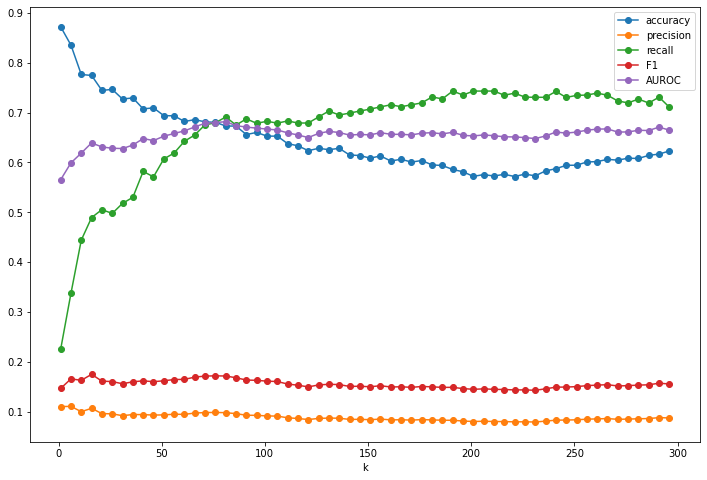

In [47]:
recall_scores = []
accuracy_scores = []
precision_scores = []
F1_scores = []
AUROC_scores = []

ks = [i for i in range(1,300,5)]
for k in ks:
    temp_SMOTE_KNN = imbpipeline([('smt', SMOTE(random_state=42)), ('pca', PCA(random_state=42)), ('knn', KNeighborsClassifier(n_neighbors=k))])
    temp_SMOTE_KNN_results = cross_validate(temp_SMOTE_KNN, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)
    
    accuracy = temp_SMOTE_KNN_results['test_accuracy'].mean()
    accuracy_scores.append(accuracy)
    
    precision = temp_SMOTE_KNN_results['test_precision'].mean()
    precision_scores.append(precision)
    
    recall = temp_SMOTE_KNN_results['test_recall'].mean()
    recall_scores.append(recall)
    
    F1 = temp_SMOTE_KNN_results['test_f1_score'].mean()
    F1_scores.append(F1)
    
    AUROC = temp_SMOTE_KNN_results['test_roc_auc'].mean()
    AUROC_scores.append(AUROC)

plt.figure(figsize=(12,8))
plt.plot(ks, accuracy_scores, 'o-', label='accuracy')
plt.plot(ks, precision_scores, 'o-', label='precision')
plt.plot(ks, recall_scores, 'o-', label='recall')
plt.plot(ks, F1_scores, 'o-', label='F1')
plt.plot(ks, AUROC_scores, 'o-', label='AUROC')
plt.xlabel('k')
plt.legend()
plt.show()

We can see that as k increases, the recall also increases at the cost of accuracy.

In [48]:
KNN_200 = KNeighborsClassifier(n_neighbors=200)
SMOTE_PCA_KNN = imbpipeline([('smt', SMOTE(random_state=42)), ('pca', PCA(random_state=42)), ('knn', KNN_200)])

In [49]:
SMOTE_PCA_KNN_results = cross_validate(SMOTE_PCA_KNN, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [50]:
print("SMOTE PCA KNN Accuracy: ", SMOTE_PCA_KNN_results['test_accuracy'].mean())
print("SMOTE PCA KNN Precision: ", SMOTE_PCA_KNN_results['test_precision'].mean())
print("SMOTE PCA KNN Recall: ", SMOTE_PCA_KNN_results['test_recall'].mean())
print("SMOTE PCA KNN F1: ", SMOTE_PCA_KNN_results['test_f1_score'].mean())
print("SMOTE PCA KNN AUROC: ", SMOTE_PCA_KNN_results['test_roc_auc'].mean())

SMOTE PCA KNN Accuracy:  0.5767248774509804
SMOTE PCA KNN Precision:  0.08036202158727154
SMOTE PCA KNN Recall:  0.7352564102564103
SMOTE PCA KNN F1:  0.14482119928471698
SMOTE PCA KNN AUROC:  0.6519313151599126


While using SMOTE does improve the recall of the KNN model significantly, the tradeoff for accuracy is a lot larger and maybe not worth it considering logistic regression does the same job with a smaller accuracy reduction.

# SVM (Support Vector Machine)

In [51]:
raw_SVM = SVC()

In [52]:
raw_SVM_results = cross_validate(raw_SVM, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [53]:
print("SVM Accuracy: ", raw_SVM_results['test_accuracy'].mean())
print("SVM Precision: ", raw_SVM_results['test_precision'].mean())
print("SVM Recall: ", raw_SVM_results['test_recall'].mean())
print("SVM F1: ", raw_SVM_results['test_f1_score'].mean())
print("SVM AUROC: ", raw_SVM_results['test_roc_auc'].mean())

SVM Accuracy:  0.9512752757352942
SVM Precision:  0.0
SVM Recall:  0.0
SVM F1:  0.0
SVM AUROC:  0.5


Without dealing with imbalanced data, SVM achieves the worst possible results. Instead of using balanced bagging, SVM has its own method for dealing with imbalanced data. According to the sklearn documentation, when setting the `class_weight` parameter to `'balanced'`, 'the `balanced` mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`. I will try this out with both the `rbf` and `linear` kernels.

In [54]:
rbf_SVM = SVC(kernel='rbf', class_weight='balanced')

In [55]:
rbf_SVM_results = cross_validate(rbf_SVM, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [56]:
print("rbf SVM Accuracy: ", rbf_SVM_results['test_accuracy'].mean())
print("rbf SVM Precision: ", rbf_SVM_results['test_precision'].mean())
print("rbf SVM Recall: ", rbf_SVM_results['test_recall'].mean())
print("rbf SVM F1: ", rbf_SVM_results['test_f1_score'].mean())
print("rbf SVM AUROC: ", rbf_SVM_results['test_roc_auc'].mean())

rbf SVM Accuracy:  0.7369845281862744
rbf SVM Precision:  0.12376600141989551
rbf SVM Recall:  0.7144230769230769
rbf SVM F1:  0.21071673344720043
rbf SVM AUROC:  0.7262710237209327


In [57]:
Linear_SVM = SVC(kernel='linear', class_weight='balanced')

In [58]:
Linear_SVM_results = cross_validate(Linear_SVM, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [59]:
print("Linear SVM Accuracy: ", Linear_SVM_results['test_accuracy'].mean())
print("Linear SVM Precision: ", Linear_SVM_results['test_precision'].mean())
print("Linear SVM Recall: ", Linear_SVM_results['test_recall'].mean())
print("Linear SVM F1: ", Linear_SVM_results['test_f1_score'].mean())
print("Linear SVM AUROC: ", Linear_SVM_results['test_roc_auc'].mean())

Linear SVM Accuracy:  0.7230882352941175
Linear SVM Precision:  0.12817535223915738
Linear SVM Recall:  0.8073717948717949
Linear SVM F1:  0.2210456223034445
Linear SVM AUROC:  0.7630779739386296


## Applying SMOTE to SVM

In [60]:
SMOTE_SVM_RBF = imbpipeline([('smt', SMOTE(random_state=42)), ('svm', SVC(kernel='rbf'))])

In [61]:
SMOTE_SVM_RBF_results = cross_validate(SMOTE_SVM_RBF, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [62]:
print("rbf SMOTE SVM Accuracy: ", SMOTE_SVM_RBF_results['test_accuracy'].mean())
print("rbf SMOTE SVM Precision: ", SMOTE_SVM_RBF_results['test_precision'].mean())
print("rbf SMOTE SVM Recall: ", SMOTE_SVM_RBF_results['test_recall'].mean())
print("rbf SMOTE SVM F1: ", SMOTE_SVM_RBF_results['test_f1_score'].mean())
print("rbf SMOTE SVM AUROC: ", SMOTE_SVM_RBF_results['test_roc_auc'].mean())

rbf SMOTE SVM Accuracy:  0.7818014705882353
rbf SMOTE SVM Precision:  0.12271432546730905
rbf SMOTE SVM Recall:  0.5621794871794872
rbf SMOTE SVM F1:  0.2011082526915758
rbf SMOTE SVM AUROC:  0.6776128833050509


In [63]:
SMOTE_SVM_Linear = imbpipeline([('smt', SMOTE(random_state=42)), ('svm', SVC(kernel='linear'))])

In [64]:
SMOTE_SVM_Linear_results = cross_validate(SMOTE_SVM_Linear, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [65]:
print("Linear SMOTE SVM Accuracy: ", SMOTE_SVM_Linear_results['test_accuracy'].mean())
print("Linear SMOTE SVM Precision: ", SMOTE_SVM_Linear_results['test_precision'].mean())
print("Linear SMOTE SVM Recall: ", SMOTE_SVM_Linear_results['test_recall'].mean())
print("Linear SMOTE SVM F1: ", SMOTE_SVM_Linear_results['test_f1_score'].mean())
print("Linear SMOTE SVM AUROC: ", SMOTE_SVM_Linear_results['test_roc_auc'].mean())

Linear SMOTE SVM Accuracy:  0.727391237745098
Linear SMOTE SVM Precision:  0.13074008864680728
Linear SMOTE SVM Recall:  0.8118589743589745
Linear SMOTE SVM F1:  0.22500046427939502
Linear SMOTE SVM AUROC:  0.7674820575093799


One conclusion we can draw is that regardless of the method for dealing with imbalanced data, the `linear` kernel will perform much better than the `rbf` kernel.

# Decision Tree

In [66]:
dt = DecisionTreeClassifier()

In [67]:
dt_results = cross_validate(dt, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [68]:
print("DT Accuracy: ", dt_results['test_accuracy'].mean())
print("DT Precision: ", dt_results['test_precision'].mean())
print("DT Recall: ", dt_results['test_recall'].mean())
print("DT F1: ", dt_results['test_f1_score'].mean())
print("DT AUROC: ", dt_results['test_roc_auc'].mean())

DT Accuracy:  0.9099892769607842
DT Precision:  0.11238388439046335
DT Recall:  0.12435897435897436
DT F1:  0.11702413864348175
DT AUROC:  0.5372886924685649


## Balanced Bagging with Decision Trees

In [69]:
balanced_bagged_dt = BalancedBaggingClassifier(base_estimator=dt, random_state=42)

In [70]:
balanced_bagged_dt_results = cross_validate(balanced_bagged_dt, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [71]:
print("Balanced Bagged DT Accuracy: ", balanced_bagged_dt_results['test_accuracy'].mean())
print("Balanced Bagged DT Precision: ", balanced_bagged_dt_results['test_precision'].mean())
print("Balanced Bagged DT Recall: ", balanced_bagged_dt_results['test_recall'].mean())
print("Balanced Bagged DT F1: ", balanced_bagged_dt_results['test_f1_score'].mean())
print("Balanced Bagged DT AUROC: ", balanced_bagged_dt_results['test_roc_auc'].mean())

Balanced Bagged DT Accuracy:  0.8064522058823531
Balanced Bagged DT Precision:  0.14596644173251905
Balanced Bagged DT Recall:  0.6134615384615383
Balanced Bagged DT F1:  0.23550572809084694
Balanced Bagged DT AUROC:  0.7148764718550692


Applying balanced bagging increases the recall of the tree, however, it is not as strong compared to other methods like logistic regression and linear SVM.

## Bagging, SMOTE, SMOTE + Bagging

In [72]:
bagged_dt = BaggingClassifier(base_estimator=dt)

In [73]:
bagged_dt_results = cross_validate(bagged_dt, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [74]:
print("Bagged DT Accuracy: ", bagged_dt_results['test_accuracy'].mean())
print("Bagged DT Precision: ", bagged_dt_results['test_precision'].mean())
print("Bagged DT Recall: ", bagged_dt_results['test_recall'].mean())
print("Bagged DT F1: ", bagged_dt_results['test_f1_score'].mean())
print("Bagged DT AUROC: ", bagged_dt_results['test_roc_auc'].mean())

Bagged DT Accuracy:  0.9450176164215687
Bagged DT Precision:  0.016666666666666666
Bagged DT Recall:  0.0038461538461538464
Bagged DT F1:  0.00625
Bagged DT AUROC:  0.4985288584787675


In [75]:
SMOTE_dt = imbpipeline([('smt', SMOTE(random_state=42)), ('dt', dt)])

In [76]:
SMOTE_dt_results = cross_validate(SMOTE_dt, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [77]:
print("SMOTE DT Accuracy: ", SMOTE_dt_results['test_accuracy'].mean())
print("SMOTE DT Precision: ", SMOTE_dt_results['test_precision'].mean())
print("SMOTE DT Recall: ", SMOTE_dt_results['test_recall'].mean())
print("SMOTE DT F1: ", SMOTE_dt_results['test_f1_score'].mean())
print("SMOTE DT AUROC: ", SMOTE_dt_results['test_roc_auc'].mean())

SMOTE DT Accuracy:  0.8624188112745099
SMOTE DT Precision:  0.12327497469652615
SMOTE DT Recall:  0.29615384615384616
SMOTE DT F1:  0.17312346054685662
SMOTE DT AUROC:  0.5937643682634576


In [78]:
bagged_SMOTE_dt = imbpipeline([('smt', SMOTE(random_state=42)), ('dt', BaggingClassifier(base_estimator=dt, random_state=42))])

In [79]:
bagged_SMOTE_dt_results = cross_validate(bagged_SMOTE_dt, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [80]:
print("Bagged SMOTE DT Accuracy: ", bagged_SMOTE_dt_results['test_accuracy'].mean())
print("Bagged SMOTE DT Precision: ", bagged_SMOTE_dt_results['test_precision'].mean())
print("Bagged SMOTE DT Recall: ", bagged_SMOTE_dt_results['test_recall'].mean())
print("Bagged SMOTE DT F1: ", bagged_SMOTE_dt_results['test_f1_score'].mean())
print("Bagged SMOTE DT AUROC: ", bagged_SMOTE_dt_results['test_roc_auc'].mean())

Bagged SMOTE DT Accuracy:  0.8888411458333334
Bagged SMOTE DT Precision:  0.11507372919777012
Bagged SMOTE DT Recall:  0.18878205128205128
Bagged SMOTE DT F1:  0.14123527911836814
Bagged SMOTE DT AUROC:  0.5567447158521838


Using regular bagging for the decision tree doesn't do much since decision trees are susceptible to imbalanced data. Despite adding SMOTE, the tree only managed to reach a recall of below 30 percent.

## Random Forest + SMOTE

In [81]:
random_forest = RandomForestClassifier(random_state=42)

In [82]:
random_forest_results = cross_validate(random_forest, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [83]:
print("Random Forest Accuracy: ", random_forest_results['test_accuracy'].mean())
print("Random Forest Precision: ", random_forest_results['test_precision'].mean())
print("Random Forest Recall: ", random_forest_results['test_recall'].mean())
print("Random Forest F1: ", random_forest_results['test_f1_score'].mean())
print("Random Forest AUROC: ", random_forest_results['test_roc_auc'].mean())

Random Forest Accuracy:  0.949709712009804
Random Forest Precision:  0.05
Random Forest Recall:  0.008012820512820512
Random Forest F1:  0.01380952380952381
Random Forest AUROC:  0.5029776036720481


In [84]:
SMOTE_forest = imbpipeline([('smt', SMOTE(random_state=42)), ('rf', random_forest)])

In [85]:
SMOTE_forest_results = cross_validate(SMOTE_forest, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [86]:
print("SMOTE Forest Accuracy: ", SMOTE_forest_results['test_accuracy'].mean())
print("SMOTE Forest Precision: ", SMOTE_forest_results['test_precision'].mean())
print("SMOTE Forest Recall: ", SMOTE_forest_results['test_recall'].mean())
print("SMOTE Forest F1: ", SMOTE_forest_results['test_f1_score'].mean())
print("Random Forest AUROC: ", SMOTE_forest_results['test_roc_auc'].mean())

SMOTE Forest Accuracy:  0.8986266850490197
SMOTE Forest Precision:  0.10905937800514794
SMOTE Forest Recall:  0.15705128205128208
SMOTE Forest F1:  0.12704900643257588
Random Forest AUROC:  0.546845987784057


## AdaBoosted Tree

In [87]:
ada_tree = AdaBoostClassifier(n_estimators=1000, learning_rate=2, random_state=42)

In [88]:
ada_tree_results = cross_validate(ada_tree, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [89]:
print("Adaboost Tree Accuracy: ", ada_tree_results['test_accuracy'].mean())
print("Adaboost Tree Precision: ", ada_tree_results['test_precision'].mean())
print("Adaboost Tree Recall: ", ada_tree_results['test_recall'].mean())
print("Adaboost Tree F1: ", ada_tree_results['test_f1_score'].mean())
print("Adaboost Tree AUROC: ", ada_tree_results['test_roc_auc'].mean())

Adaboost Tree Accuracy:  0.7428890931372549
Adaboost Tree Precision:  0.08914472124178771
Adaboost Tree Recall:  0.41698717948717945
Adaboost Tree F1:  0.14099543822587804
Adaboost Tree AUROC:  0.5881232193732194


## Gradient Boosted Tree

In [90]:
gradient_tree = GradientBoostingClassifier(n_estimators=1000, max_depth=3, learning_rate=2.5, random_state=42)

In [91]:
gradient_tree_results = cross_validate(gradient_tree, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [92]:
print("Gradient Tree Accuracy: ", gradient_tree_results['test_accuracy'].mean())
print("Gradient Tree Precision: ", gradient_tree_results['test_precision'].mean())
print("Gradient Tree Recall: ", gradient_tree_results['test_recall'].mean())
print("Gradient Tree F1: ", gradient_tree_results['test_f1_score'].mean())
print("Gradient Tree AUROC: ", gradient_tree_results['test_roc_auc'].mean())

Gradient Tree Accuracy:  0.48255667892156867
Gradient Tree Precision:  0.09198272526507247
Gradient Tree Recall:  0.6580128205128205
Gradient Tree F1:  0.15048382570145433
Gradient Tree AUROC:  0.5658267232834627


While boosting methods can work in increasing recall, the tradeoff in accuracy is too big compared to other models.

# Neural Nets

In [93]:
clf = MLPClassifier(learning_rate='constant', max_iter=100, random_state=42)

In [94]:
clf_results =  cross_validate(clf, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [95]:
print("Neural Net Accuracy: ", clf_results['test_accuracy'].mean())
print("Neural Net Precision: ", clf_results['test_precision'].mean())
print("Neural Net Recall: ", clf_results['test_recall'].mean())
print("Neural Net F1: ", clf_results['test_f1_score'].mean())
print("Neural Net AUROC: ", clf_results['test_roc_auc'].mean())

Neural Net Accuracy:  0.950686274509804
Neural Net Precision:  0.1
Neural Net Recall:  0.008012820512820512
Neural Net F1:  0.014835164835164838
Neural Net AUROC:  0.5034920069642292


## Applying SMOTE

In [96]:
clf = MLPClassifier(learning_rate='constant', max_iter=100, random_state=42)

In [97]:
SMOTE_clf = imbpipeline([('smt', SMOTE(random_state=42)), ('clf', clf)])

In [98]:
SMOTE_clf_results =  cross_validate(SMOTE_clf, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [99]:
print("Neural Net Accuracy: ", SMOTE_clf_results['test_accuracy'].mean())
print("Neural Net Precision: ", SMOTE_clf_results['test_precision'].mean())
print("Neural Net Recall: ", SMOTE_clf_results['test_recall'].mean())
print("Neural Net F1: ", SMOTE_clf_results['test_f1_score'].mean())
print("Neural Net AUROC: ", SMOTE_clf_results['test_roc_auc'].mean())

Neural Net Accuracy:  0.8127267156862746
Neural Net Precision:  0.13010703226193643
Neural Net Recall:  0.4980769230769231
Neural Net F1:  0.20581888051145017
Neural Net AUROC:  0.6634615708955418


## Tuning Max_iter

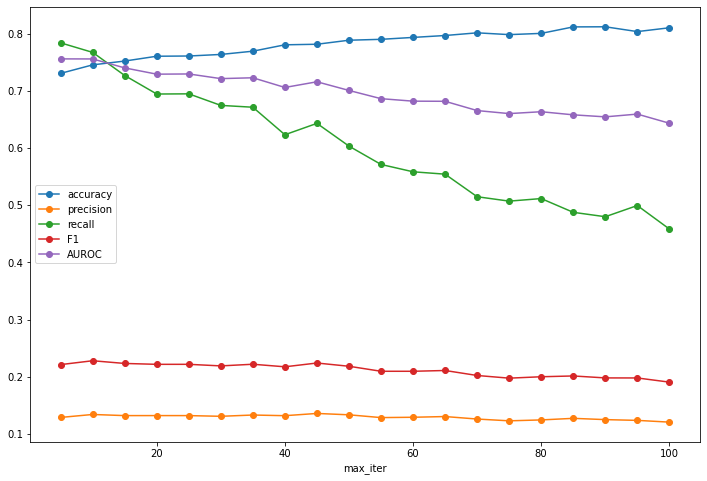

In [100]:
recall_scores = []
accuracy_scores = []
precision_scores = []
F1_scores = []
AUROC_scores = []

iters = [i for i in range(5,101,5)]
for i in iters:
    temp_clf = MLPClassifier(learning_rate='constant', max_iter=i, random_state=42)
    temp_SMOTE_clf = imbpipeline([('smt', SMOTE(random_state=42)), ('pca', PCA()), ('clf', temp_clf)])
    temp_SMOTE_clf_results = cross_validate(temp_SMOTE_clf, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)
    
    accuracy = temp_SMOTE_clf_results['test_accuracy'].mean()
    accuracy_scores.append(accuracy)
    
    precision = temp_SMOTE_clf_results['test_precision'].mean()
    precision_scores.append(precision)
    
    recall = temp_SMOTE_clf_results['test_recall'].mean()
    recall_scores.append(recall)
    
    f1 = temp_SMOTE_clf_results['test_f1_score'].mean()
    F1_scores.append(f1)
    
    AUROC = temp_SMOTE_clf_results['test_roc_auc'].mean()
    AUROC_scores.append(AUROC)

plt.figure(figsize=(12,8))
plt.plot(iters, accuracy_scores, 'o-', label='accuracy')
plt.plot(iters, precision_scores, 'o-', label='precision')
plt.plot(iters, recall_scores, 'o-', label='recall')
plt.plot(iters, F1_scores, 'o-', label='F1')
plt.plot(iters, AUROC_scores, 'o-', label='AUROC')
plt.xlabel('max_iter')
plt.legend()
plt.show()

In [101]:
clf = MLPClassifier(learning_rate='constant', max_iter=7, random_state=42)

In [102]:
SMOTE_clf = imbpipeline([('smt', SMOTE(random_state=42)), ('clf', clf)])

In [103]:
SMOTE_clf_results =  cross_validate(SMOTE_clf, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [104]:
print("Neural Net Accuracy: ", SMOTE_clf_results['test_accuracy'].mean())
print("Neural Net Precision: ", SMOTE_clf_results['test_precision'].mean())
print("Neural Net Recall: ", SMOTE_clf_results['test_recall'].mean())
print("Neural Net F1: ", SMOTE_clf_results['test_f1_score'].mean())
print("Neural Net AUROC: ", SMOTE_clf_results['test_roc_auc'].mean())

Neural Net Accuracy:  0.750494025735294
Neural Net Precision:  0.136228563687329
Neural Net Recall:  0.7676282051282053
Neural Net F1:  0.2310130567269278
Neural Net AUROC:  0.7586370129061385


After testing various values for `max_iter`, the best value would be around `5`. Increasing the value will cause the model to increase its accuracy but decrease its recall, which is not the main objective.

## Tuning hidden layer size

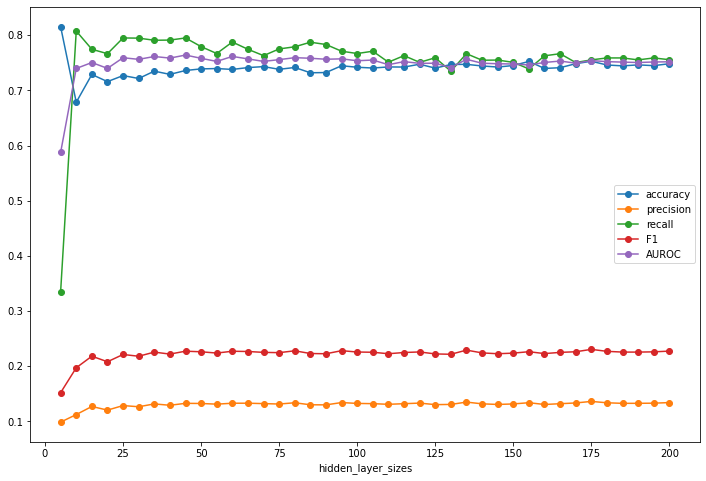

In [105]:
recall_scores = []
accuracy_scores = []
precision_scores = []
F1_scores = []
AUROC_scores = []
layers = [i for i in range(5,201,5)]
for i in layers:
    temp_clf = MLPClassifier(hidden_layer_sizes=i, learning_rate='constant', max_iter=7, random_state=42)
    temp_SMOTE_clf = imbpipeline([('smt', SMOTE(random_state=42)), ('pca', PCA()), ('clf', temp_clf)])
    temp_SMOTE_clf_results = cross_validate(temp_SMOTE_clf, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)
    
    accuracy = temp_SMOTE_clf_results['test_accuracy'].mean()
    accuracy_scores.append(accuracy)
    
    precision = temp_SMOTE_clf_results['test_precision'].mean()
    precision_scores.append(precision)
    
    recall = temp_SMOTE_clf_results['test_recall'].mean()
    recall_scores.append(recall)
    
    f1 = temp_SMOTE_clf_results['test_f1_score'].mean()
    F1_scores.append(f1)
    
    AUROC = temp_SMOTE_clf_results['test_roc_auc'].mean()
    AUROC_scores.append(AUROC)

plt.figure(figsize=(12,8))
plt.plot(layers, accuracy_scores, 'o-', label='accuracy')
plt.plot(layers, precision_scores, 'o-', label='precision')
plt.plot(layers, recall_scores, 'o-', label='recall')
plt.plot(layers, F1_scores, 'o-', label='F1')
plt.plot(layers, AUROC_scores, 'o-', label='AUROC')
plt.xlabel('hidden_layer_sizes')
plt.legend()
plt.show()

In [106]:
clf = MLPClassifier(hidden_layer_sizes=10, learning_rate='constant', max_iter=7, random_state=42)

In [107]:
SMOTE_clf = imbpipeline([('smt', SMOTE(random_state=42)), ('pca', PCA()), ('clf', clf)])

In [108]:
SMOTE_clf_results =  cross_validate(SMOTE_clf, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [109]:
print("Neural Net Accuracy: ", SMOTE_clf_results['test_accuracy'].mean())
print("Neural Net Precision: ", SMOTE_clf_results['test_precision'].mean())
print("Neural Net Recall: ", SMOTE_clf_results['test_recall'].mean())
print("Neural Net F1: ", SMOTE_clf_results['test_f1_score'].mean())
print("Neural Net AUROC: ", SMOTE_clf_results['test_roc_auc'].mean())

Neural Net Accuracy:  0.6786634497549018
Neural Net Precision:  0.11247843819566727
Neural Net Recall:  0.8076923076923077
Neural Net F1:  0.1973137162688417
Neural Net AUROC:  0.7398872723781649


While an early increase in `hidden_layer_sizes` will increase the recall greatly, overall, `hidden_layer_sizes` doesn't seem to affect the recall or accurate too much.

# Continuing further with Logistic Regression and Linear SVM

I will be continuing will Logistic regression and Linear SVM since they are models that offer the greatest amount of recall for the smallest reduction in accuracy. While most models start of with a very high accuracy and very low recall, after applying SMOTE, logistic regression and linear SVM are some of the only models that can achieve both accuracy and recall around or over 70 percent. To further continue, I will be comparing the various solvers and penalties logistic regression has to offer.

## Further tuning with Logistic Regression

In [110]:
logit = LogisticRegression(penalty='l2', solver='lbfgs')

In [111]:
SMOTE_PCA_logit = imbpipeline([('smt', SMOTE(random_state=42)), ('pca', PCA()), ('logit', logit)])

In [112]:
SMOTE_PCA_logit_results = cross_validate(SMOTE_PCA_logit, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [113]:
print("SMOTE PCA Logistic Accuracy: ", SMOTE_PCA_logit_results['test_accuracy'].mean())
print("SMOTE PCA Logistic Precision: ", SMOTE_PCA_logit_results['test_precision'].mean())
print("SMOTE PCA Logistic Recall: ", SMOTE_PCA_logit_results['test_recall'].mean())
print("SMOTE PCA Logistic F1: ", SMOTE_PCA_logit_results['test_f1_score'].mean())
print("SMOTE PCA Logistic AUROC: ", SMOTE_PCA_logit_results['test_roc_auc'].mean())

SMOTE PCA Logistic Accuracy:  0.7408923100490196
SMOTE PCA Logistic Precision:  0.1322668937208131
SMOTE PCA Logistic Recall:  0.7756410256410257
SMOTE PCA Logistic F1:  0.22572393092236717
SMOTE PCA Logistic AUROC:  0.7573952446561736


In [114]:
logit = LogisticRegression(penalty='none', solver='lbfgs')

In [115]:
SMOTE_PCA_logit = imbpipeline([('smt', SMOTE(random_state=42)), ('pca', PCA()), ('logit', logit)])

In [116]:
SMOTE_PCA_logit_results = cross_validate(SMOTE_PCA_logit, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [117]:
print("SMOTE PCA Logistic Accuracy: ", SMOTE_PCA_logit_results['test_accuracy'].mean())
print("SMOTE PCA Logistic Precision: ", SMOTE_PCA_logit_results['test_precision'].mean())
print("SMOTE PCA Logistic Recall: ", SMOTE_PCA_logit_results['test_recall'].mean())
print("SMOTE PCA Logistic F1: ", SMOTE_PCA_logit_results['test_f1_score'].mean())
print("SMOTE PCA Logistic AUROC: ", SMOTE_PCA_logit_results['test_roc_auc'].mean())

SMOTE PCA Logistic Accuracy:  0.7418742340686274
SMOTE PCA Logistic Precision:  0.13317475165168513
SMOTE PCA Logistic Recall:  0.7794871794871795
SMOTE PCA Logistic F1:  0.22723373774116323
SMOTE PCA Logistic AUROC:  0.7597298442129954


In [118]:
logit = LogisticRegression(penalty='l1', solver='liblinear')

In [119]:
SMOTE_PCA_logit = imbpipeline([('smt', SMOTE(random_state=42)), ('pca', PCA()), ('logit', logit)])

In [120]:
SMOTE_PCA_logit_results = cross_validate(SMOTE_PCA_logit, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [121]:
print("SMOTE PCA Logistic Accuracy: ", SMOTE_PCA_logit_results['test_accuracy'].mean())
print("SMOTE PCA Logistic Precision: ", SMOTE_PCA_logit_results['test_precision'].mean())
print("SMOTE PCA Logistic Recall: ", SMOTE_PCA_logit_results['test_recall'].mean())
print("SMOTE PCA Logistic F1: ", SMOTE_PCA_logit_results['test_f1_score'].mean())
print("SMOTE PCA Logistic AUROC: ", SMOTE_PCA_logit_results['test_roc_auc'].mean())

SMOTE PCA Logistic Accuracy:  0.7418719362745098
SMOTE PCA Logistic Precision:  0.1332094414114619
SMOTE PCA Logistic Recall:  0.7794871794871795
SMOTE PCA Logistic F1:  0.22727777636510246
SMOTE PCA Logistic AUROC:  0.7597298442129954


## Determining the penalty coefficient.

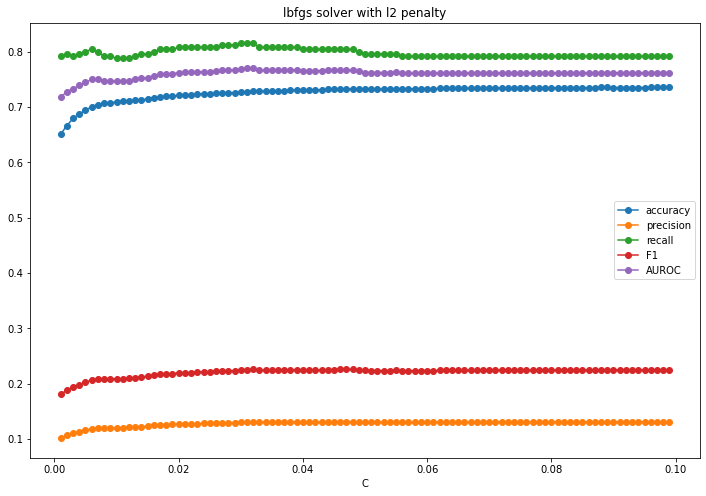

In [122]:
recall_scores = []
accuracy_scores = []
precision_scores = []
F1_scores = []
AUROC_scores = []

Cs = list(np.arange(.001, .1, .001))
for i in Cs:
    temp_logit = LogisticRegression(penalty='l2', C=i, solver='lbfgs')
    temp_SMOTE_PCA_logit = imbpipeline([('smt', SMOTE(random_state=42)), ('pca', PCA()), ('logit', temp_logit)])
    temp_SMOTE_PCA_logit_results = cross_validate(temp_SMOTE_PCA_logit, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)
    
    accuracy = temp_SMOTE_PCA_logit_results['test_accuracy'].mean()
    accuracy_scores.append(accuracy)
    
    precision = temp_SMOTE_PCA_logit_results['test_precision'].mean()
    precision_scores.append(precision)
    
    recall = temp_SMOTE_PCA_logit_results['test_recall'].mean()
    recall_scores.append(recall)
    
    f1 = temp_SMOTE_PCA_logit_results['test_f1_score'].mean()
    F1_scores.append(f1)

    AUROC = temp_SMOTE_PCA_logit_results['test_roc_auc'].mean()
    AUROC_scores.append(AUROC)
    
    

plt.figure(figsize=(12,8))
plt.plot(Cs, accuracy_scores, 'o-', label='accuracy')
plt.plot(Cs, precision_scores, 'o-', label='precision')
plt.plot(Cs, recall_scores, 'o-', label='recall')
plt.plot(Cs, F1_scores, 'o-', label='F1')
plt.plot(Cs, AUROC_scores, 'o-', label='AUROC')
plt.xlabel('C')
plt.legend()
plt.title('lbfgs solver with l2 penalty')
plt.show()

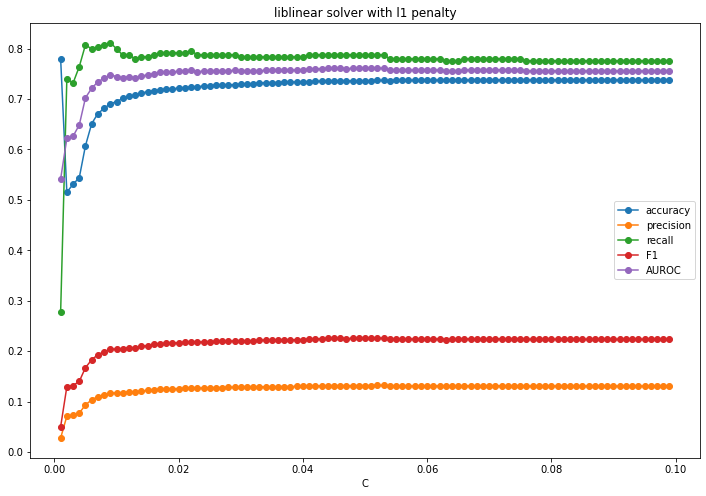

In [123]:
recall_scores = []
accuracy_scores = []
precision_scores = []
F1_scores = []
AUROC_scores = []

Cs = list(np.arange(.001, .1, .001))
for i in Cs:
    temp_logit = LogisticRegression(penalty='l1', C=i, solver='liblinear')
    temp_SMOTE_PCA_logit = imbpipeline([('smt', SMOTE(random_state=42)), ('pca', PCA()), ('logit', temp_logit)])
    temp_SMOTE_PCA_logit_results = cross_validate(temp_SMOTE_PCA_logit, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)
    
    accuracy = temp_SMOTE_PCA_logit_results['test_accuracy'].mean()
    accuracy_scores.append(accuracy)
    
    precision = temp_SMOTE_PCA_logit_results['test_precision'].mean()
    precision_scores.append(precision)
    
    recall = temp_SMOTE_PCA_logit_results['test_recall'].mean()
    recall_scores.append(recall)
    
    f1 = temp_SMOTE_PCA_logit_results['test_f1_score'].mean()
    F1_scores.append(f1)

    AUROC = temp_SMOTE_PCA_logit_results['test_roc_auc'].mean()
    AUROC_scores.append(AUROC)

plt.figure(figsize=(12,8))
plt.plot(Cs, accuracy_scores, 'o-', label='accuracy')
plt.plot(Cs, precision_scores, 'o-', label='precision')
plt.plot(Cs, recall_scores, 'o-', label='recall')
plt.plot(Cs, F1_scores, 'o-', label='F1')
plt.plot(Cs, AUROC_scores, 'o-', label='AUROC')
plt.xlabel('C')
plt.legend()
plt.title('liblinear solver with l1 penalty')
plt.show()

In [124]:
logit = LogisticRegression(penalty='l1', C=.03, solver='liblinear')

In [125]:
SMOTE_PCA_logit = imbpipeline([('smt', SMOTE(random_state=42)), ('pca', PCA()), ('logit', logit)])

In [126]:
SMOTE_PCA_logit_results = cross_validate(SMOTE_PCA_logit, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [127]:
print("SMOTE PCA Logistic Accuracy: ", SMOTE_PCA_logit_results['test_accuracy'].mean())
print("SMOTE PCA Logistic Precision: ", SMOTE_PCA_logit_results['test_precision'].mean())
print("SMOTE PCA Logistic Recall: ", SMOTE_PCA_logit_results['test_recall'].mean())
print("SMOTE PCA Logistic F1: ", SMOTE_PCA_logit_results['test_f1_score'].mean())
print("SMOTE PCA Logistic AUROC: ", SMOTE_PCA_logit_results['test_roc_auc'].mean())

SMOTE PCA Logistic Accuracy:  0.7291498161764706
SMOTE PCA Logistic Precision:  0.1278064564919947
SMOTE PCA Logistic Recall:  0.7836538461538461
SMOTE PCA Logistic F1:  0.21951675495606274
SMOTE PCA Logistic AUROC:  0.7550234757315815


We can see that a very small `C` value around `.01` will give a slight increase in recall performance. I will opt to continue with the `liblinear` solver since it offers a slightly better recall performance than `lbfgs`.

## Further tuning with Linear SVM

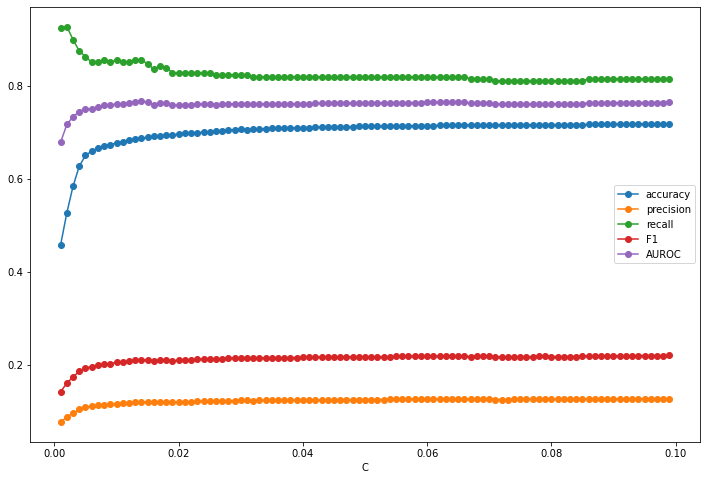

In [128]:
recall_scores = []
accuracy_scores = []
precision_scores = []
F1_scores = []
AUROC_scores = []

Cs = list(np.arange(.001, .1, .001))
for i in Cs:
    temp_linear_SVM = SVC(C=i, kernel='linear')
    temp_SMOTE_PCA_SVM = imbpipeline([('smt', SMOTE(random_state=42)), ('pca', PCA()), ('svm', temp_linear_SVM)])
    temp_SMOTE_PCA_SVM_results = cross_validate(temp_SMOTE_PCA_SVM, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)
    
    accuracy = temp_SMOTE_PCA_SVM_results['test_accuracy'].mean()
    accuracy_scores.append(accuracy)
    
    precision = temp_SMOTE_PCA_SVM_results['test_precision'].mean()
    precision_scores.append(precision)
    
    recall = temp_SMOTE_PCA_SVM_results['test_recall'].mean()
    recall_scores.append(recall)
    
    f1 = temp_SMOTE_PCA_SVM_results['test_f1_score'].mean()
    F1_scores.append(f1)
    
    AUROC = temp_SMOTE_PCA_SVM_results['test_roc_auc'].mean()
    AUROC_scores.append(AUROC)

plt.figure(figsize=(12,8))
plt.plot(Cs, accuracy_scores, 'o-', label='accuracy')
plt.plot(Cs, precision_scores, 'o-', label='precision')
plt.plot(Cs, recall_scores, 'o-', label='recall')
plt.plot(Cs, F1_scores, 'o-', label='F1')
plt.plot(Cs, AUROC_scores, 'o-', label='AUROC')
plt.xlabel('C')
plt.legend()
plt.show()

In [129]:
linear_SVM = SVC(C=.1, kernel='linear')

In [130]:
SMOTE_SVM_Linear = imbpipeline([('smt', SMOTE(random_state=42)), ('pca', PCA()), ('svm', linear_SVM)])

In [131]:
SMOTE_SVM_Linear_results = cross_validate(SMOTE_SVM_Linear, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [132]:
print("Linear SVM Accuracy: ", SMOTE_SVM_Linear_results['test_accuracy'].mean())
print("Linear SVM Precision: ", SMOTE_SVM_Linear_results['test_precision'].mean())
print("Linear SVM Recall: ", SMOTE_SVM_Linear_results['test_recall'].mean())
print("Linear SVM F1: ", SMOTE_SVM_Linear_results['test_f1_score'].mean())
print("Linear SVM AUROC: ", SMOTE_SVM_Linear_results['test_roc_auc'].mean())

Linear SVM Accuracy:  0.7189736519607842
Linear SVM Precision:  0.12759808597248776
Linear SVM Recall:  0.8157051282051283
Linear SVM F1:  0.2204743360784786
Linear SVM AUROC:  0.7648783854612635


For linear SVM, a small `C` value around `.001` will give the model a recall of almost .9, the highest tested yet. However, the tradeoff in accuracy might be too huge so a more optimal `C` will be around `.1`. As `C` increases, recall will also increase as accuracy decreases. It really depends on how much the user values recall and accuracy. The results with linear SVM are slightly better than the results with logistic regression. As seen earlier, the choice of kernel for SVM does matter as `linear` performs a lot better than `rbf`. While linear SVM does perform slightly better than logistic regression, it is important to keep in mind that SVM is a little slower.

# Final Results

In [133]:
final_logit =  LogisticRegression(penalty='l1', C=.009, solver='liblinear')

In [134]:
final_SMOTE_logit = imbpipeline([('smt', SMOTE(random_state=42)), ('pca', PCA()), ('logit', final_logit)])

In [135]:
final_SMOTE_logit_results = cross_validate(final_SMOTE_logit, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [136]:
print("Final SMOTE Logistic Accuracy: ", final_SMOTE_logit_results['test_accuracy'].mean())
print("Final SMOTE Logistic Precision: ", final_SMOTE_logit_results['test_precision'].mean())
print("Final SMOTE Logistic Recall: ", final_SMOTE_logit_results['test_recall'].mean())
print("Final SMOTE Logistic F1: ", final_SMOTE_logit_results['test_f1_score'].mean())
print("Final SMOTE Logistic AUROC: ", final_SMOTE_logit_results['test_roc_auc'].mean())

Final SMOTE Logistic Accuracy:  0.6906089154411765
Final SMOTE Logistic Precision:  0.11685828441209016
Final SMOTE Logistic Recall:  0.8118589743589743
Final SMOTE Logistic F1:  0.20405800212549458
Final SMOTE Logistic AUROC:  0.7481442885017566


In [137]:
final_linear_SVM = SVC(C=.01, kernel='linear')

In [138]:
final_SMOTE_SVM_Linear = imbpipeline([('smt', SMOTE(random_state=42)), ('pca', PCA()), ('svm', final_linear_SVM)])

In [139]:
final_SMOTE_SVM_Linear_results = cross_validate(final_SMOTE_SVM_Linear, df_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [140]:
print("Final Linear SVM Accuracy: ", final_SMOTE_SVM_Linear_results['test_accuracy'].mean())
print("Final Linear SVM Precision: ", final_SMOTE_SVM_Linear_results['test_precision'].mean())
print("Final Linear SVM Recall: ", final_SMOTE_SVM_Linear_results['test_recall'].mean())
print("Final Linear SVM F1: ", final_SMOTE_SVM_Linear_results['test_f1_score'].mean())
print("Final Linear SVM AUROC: ", final_SMOTE_SVM_Linear_results['test_roc_auc'].mean())

Final Linear SVM Accuracy:  0.6778783700980391
Final Linear SVM Precision:  0.11706833326099486
Final Linear SVM Recall:  0.8560897435897437
Final Linear SVM F1:  0.2058128794276782
Final Linear SVM AUROC:  0.7624403214339461
